In [74]:
#!/usr/bin/env python
# This program is free software; you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation; either version 2 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# Copyright 2022 Jorgen Bergstrom
import sys
import numpy as np
import math
from matplotlib import pyplot as plt
## Input file syntax:
##    *Node
##    1, 0.0, 0.0
##    2, 0.0, 1.0
##    3, 1.0, 1.0
##    4, 1.0, 0.0
##    *Element
##    1, 1, 2, 3, 4
##    *Step
##    *Boundary
##    1, 1, 2, 0.0          # nodeId, dof1, dof2, value
##    2, 1, 1, 0.0
##    3, 1, 1, 0.01
##    4, 1, 1, 0.01
##    4, 2, 2, 0.0

def shape(xi):
	"""Shape functions for a 4-node, isoparametric element
		N_i(xi,eta) where i=[1,2,3,4]
		Input: 1x2,  Output: 1x4"""
	xi,eta = tuple(xi)
	N = [(1.0-xi)*(1.0-eta), (1.0+xi)*(1.0-eta), (1.0+xi)*(1.0+eta), (1.0-xi)*(1.0+eta)]
	return 0.25 * np.array(N)
def gradshape(xi):
	"""Gradient of the shape functions for a 4-node, isoparametric element.
		dN_i(xi,eta)/dxi and dN_i(xi,eta)/deta
		Input: 1x2,  Output: 2x4"""
	xi,eta = tuple(xi)
	dN = [[-(1.0-eta),  (1.0-eta), (1.0+eta), -(1.0+eta)],
		  [-(1.0-xi), -(1.0+xi), (1.0+xi),  (1.0-xi)]]
	return 0.25 * np.array(dN)
def local_error(str):
	print("*** ERROR ***")
	print(str)
	sys.exit(3)
def read_inp_file(inpFileName, nodes, conn, boundary):
	print('\n** Read input file')
	inpFile = open(inpFileName, 'r')
	lines = inpFile.readlines()
	inpFile.close()
	state = 0
	for line in lines:
		line = line.strip()
		if len(line) <= 0: continue
		if line[0] == '*':
			state = 0
		if line.lower() == "*node":
			state = 1
			continue
		if line.lower() == "*element":
			state = 2
			continue
		if line.lower() == "*boundary":
			state = 3
			continue
		if state == 0:
			continue
		if state == 1:
			# read nodes
			values = line.split(",")
			if len(values) != 3:
				local_error("A node definition needs 3 values")
			nodeNr = int(values[0]) - 1  # zero indexed
			xx = float(values[1])
			yy = float(values[2])
			nodes.append([xx,yy])   # assume the nodes are ordered 1, 2, 3...
			continue
		if state == 2:
			# read elements
			values = line.split(",")
			if len(values) != 5:
				local_error("An element definition needs 5 values")
			elemNr = int(values[0])
			n1 = int(values[1]) - 1  # zero indexed
			n2 = int(values[2]) - 1
			n3 = int(values[3]) - 1
			n4 = int(values[4]) - 1
			#conn.append([n1, n2, n3, n4]) # assume elements ordered 1, 2, 3
			conn.append([n1, n4, n3, n2]) # assume elements ordered 1, 2, 3
			continue
		if state == 3:
			# read displacement boundary conditions
			values = line.split(",")
			if len(values) != 4:
				local_error("A displacement boundary condition needs 4 values")
			nodeNr = int(values[0]) - 1  # zero indexed
			dof1 = int(values[1])
			dof2 = int(values[2])
			val = float(values[3])
			if dof1 == 1:
				boundary.append([nodeNr,1,val])
			if dof2 == 2:
				boundary.append([nodeNr,2,val])
			continue


In [75]:
def FEM(nodes, conn, boundary, load):
    nodes = np.array(nodes)
    num_nodes = len(nodes)
    print('   number of nodes:', len(nodes))
    print('   number of elements:', len(conn))
    print('   number of displacement boundary conditions:', len(boundary))

    ###############################
    # Plane-strain material tangent (see Bathe p. 194)
    # C is 3x3
    E = 100.0
    v = 0.3
    C = E/(1.0+v)/(1.0-2.0*v) * np.array([[1.0-v, v, 0.0], [v, 1.0-v, 0.0], [0.0, 0.0, 0.5-v]])
    ###############################
    # Make stiffness matrix
    # if N is the number of DOF, then K is NxN
    K = np.zeros((2*num_nodes, 2*num_nodes))    # square zero matrix
    # 2x2 Gauss Quadrature (4 Gauss points)
    # q4 is 4x2
    q4 = np.array([[-1,-1],[1,-1],[-1,1],[1,1]]) / math.sqrt(3.0)
    # print('\n** Assemble stiffness matrix')
    # strain in an element: [strain] = B    U
    #                        3x1     = 3x8  8x1
    #
    # strain11 = B11 U1 + B12 U2 + B13 U3 + B14 U4 + B15 U5 + B16 U6 + B17 U7 + B18 U8
    #          = B11 u1          + B13 u1          + B15 u1          + B17 u1
    #          = dN1/dx u1       + dN2/dx u1       + dN3/dx u1       + dN4/dx u1
    B = np.zeros((3,8))
    # conn[0] is node numbers of the element
    for c in conn:     # loop through each element
        # coordinates of each node in the element
        # shape = 4x2
        # for example:
        #    nodePts = [[0.0,   0.0],
        #               [0.033, 0.0],
        #               [0.033, 0.066],
        #               [0.0,   0.066]]
        nodePts = nodes[c,:]
        Ke = np.zeros((8,8))	# element stiffness matrix is 8x8
        for q in q4:			# for each Gauss point
            # q is 1x2, N(xi,eta)
            dN = gradshape(q)       # partial derivative of N wrt (xi,eta): 2x4
            J  = np.dot(dN, nodePts).T # J is 2x2
            dN = np.dot(np.linalg.inv(J), dN)    # partial derivative of N wrt (x,y): 2x4
            # assemble B matrix  [3x8]
            B[0,0::2] = dN[0,:]
            B[1,1::2] = dN[1,:]
            B[2,0::2] = dN[1,:]
            B[2,1::2] = dN[0,:]
            # element stiffness matrix
            Ke += np.dot(np.dot(B.T,C),B) * np.linalg.det(J)
        # Scatter operation
        for i,I in enumerate(c):
            for j,J in enumerate(c):
                K[2*I,2*J]     += Ke[2*i,2*j]
                K[2*I+1,2*J]   += Ke[2*i+1,2*j]
                K[2*I+1,2*J+1] += Ke[2*i+1,2*j+1]
                K[2*I,2*J+1]   += Ke[2*i,2*j+1]
    ###############################
    # Assign nodal forces and boundary conditions
    #    if N is the number of nodes, then f is 2xN
    f = np.zeros((2*num_nodes))          # initialize to 0 forces
    assemble_load(nodes, load, f)
    # How about displacement boundary conditions:
    #    [k11 k12 k13] [u1] = [f1]
    #    [k21 k22 k23] [u2]   [f2]
    #    [k31 k32 k33] [u3]   [f3]
    #
    #    if u3=x then
    #       [k11 k12 k13] [u1] = [f1]
    #       [k21 k22 k23] [u2]   [f2]
    #       [k31 k32 k33] [ x]   [f3]
    #   =>
    #       [k11 k12 k13] [u1] = [f1]
    #       [k21 k22 k23] [u2]   [f2]
    #       [  0   0   1] [u3]   [ x]
    #   the reaction force is
    #       f3 = [k31 k32 k33] * [u1 u2 u3]
    for i in range(len(boundary)):  # apply all boundary displacements
        nn  = boundary[i][0]
        dof = boundary[i][1]
        val = boundary[i][2]
        j = 2*nn
        if dof == 2: j = j + 1
        K[j,:] = 0.0
        K[j,j] = 1.0
        f[j] = val
    ###############################
    # print('\n** Solve linear system: Ku = f')	# [K] = 2N x 2N, [f] = 2N x 1, [u] = 2N x 1
    u = np.linalg.solve(K, f)
    ###############################
    # print('\n** Post process the data')
    # (pre-allocate space for nodal stress and strain)
    node_strain = []
    node_stress = []
    for ni in range(len(nodes)):
        node_strain.append([0.0, 0.0, 0.0])
        node_stress.append([0.0, 0.0, 0.0])
    node_strain = np.array(node_strain)
    node_stress = np.array(node_stress)

    print(f'   min displacements: u1={min(u[0::2]):.4g}, u2={min(u[1::2]):.4g}')
    print(f'   max displacements: u1={max(u[0::2]):.4g}, u2={max(u[1::2]):.4g}')
    emin = np.array([ 9.0e9,  9.0e9,  9.0e9])
    emax = np.array([-9.0e9, -9.0e9, -9.0e9])
    smin = np.array([ 9.0e9,  9.0e9,  9.0e9])
    smax = np.array([-9.0e9, -9.0e9, -9.0e9])

    # Initialize variables for average calculation
    total_strain = np.zeros(3)
    total_stress = np.zeros(3)
    num_elements = len(conn)

    for c in conn:  # for each element (conn is Nx4)
        nodePts = nodes[c,:]  # 4x2, eg: [[1.1,0.2], [1.2,0.3], [1.3,0.4], [1.4, 0.5]]
        for q in q4:  # for each integration pt, eg: [-0.7,-0.7]
            dN = gradshape(q)  # 2x4
            J  = np.dot(dN, nodePts).T  # 2x2
            dN = np.dot(np.linalg.inv(J), dN)  # 2x4
            B[0,0::2] = dN[0,:]  # 3x8
            B[1,1::2] = dN[1,:]
            B[2,0::2] = dN[1,:]
            B[2,1::2] = dN[0,:]

            UU = np.zeros((8,1))  # 8x1
            UU[0] = u[2*c[0]]
            UU[1] = u[2*c[0] + 1]
            UU[2] = u[2*c[1]]
            UU[3] = u[2*c[1] + 1]
            UU[4] = u[2*c[2]]
            UU[5] = u[2*c[2] + 1]
            UU[6] = u[2*c[3]]
            UU[7] = u[2*c[3] + 1]
            # get the strain and stress at the integration point
            strain = B @ UU  # (B is 3x8) (UU is 8x1) => (strain is 3x1)
            stress = C @ strain  # (C is 3x3) (strain is 3x1) => (stress is 3x1)
            emin[0] = min(emin[0], strain[0][0])
            emin[1] = min(emin[1], strain[1][0])
            emin[2] = min(emin[2], strain[2][0])
            emax[0] = max(emax[0], strain[0][0])
            emax[1] = max(emax[1], strain[1][0])
            emax[2] = max(emax[2], strain[2][0])

            node_strain[c[0]][:] = strain.T[0]
            node_strain[c[1]][:] = strain.T[0]
            node_strain[c[2]][:] = strain.T[0]
            node_strain[c[3]][:] = strain.T[0]
            node_stress[c[0]][:] = stress.T[0]
            node_stress[c[1]][:] = stress.T[0]
            node_stress[c[2]][:] = stress.T[0]
            node_stress[c[3]][:] = stress.T[0]
            smax[0] = max(smax[0], stress[0][0])
            smax[1] = max(smax[1], stress[1][0])
            smax[2] = max(smax[2], stress[2][0])
            smin[0] = min(smin[0], stress[0][0])
            smin[1] = min(smin[1], stress[1][0])
            smin[2] = min(smin[2], stress[2][0])

            # Accumulate total strain and stress for average calculation
            total_strain += strain.T[0]
            total_stress += stress.T[0]

    # Calculate average strain and stress
    average_strain = total_strain / num_elements
    average_stress = total_stress / num_elements

    print(f'   min strains: e11={emin[0]:.4g}, e22={emin[1]:.4g}, e12={emin[2]:.4g}')
    print(f'   max strains: e11={emax[0]:.4g}, e22={emax[1]:.4g}, e12={emax[2]:.4g}')
    print(f'   min stress:  s11={smin[0]:.4g}, s22={smin[1]:.4g}, s12={smin[2]:.4g}')
    print(f'   max stress:  s11={smax[0]:.4g}, s22={smax[1]:.4g}, s12={smax[2]:.4g}')
    print(f'   average strains: e11={average_strain[0]:.4g}, e22={average_strain[1]:.4g}, e12={average_strain[2]:.4g}')
    print(f'   average stress:  s11={average_stress[0]:.4g}, s22={average_stress[1]:.4g}, s12={average_stress[2]:.4g}')
    print(f'   average strain/nodes:  s11={abs((average_stress[0])/len(conn))*10000:.4g}, s22={(abs(average_stress[1])/len(conn))*10000:.4g}, s12={(abs(average_stress[2])/len(conn))*10000:.4g}')
    print(f'   average strain/nodes:  e11={abs((average_strain[0])/len(conn))*10000:.4g}, e22={(abs(average_strain[1])/len(conn))*10000:.4g}, e12={(abs(average_strain[2])/len(conn))*10000:.4g}')    
        ###############################
    # print('\n** Plot displacement')
    xvec = []
    yvec = []
    res  = []
    plot_type = 'e11'
    for ni, pt in enumerate(nodes):
        xvec.append(pt[1] + u[2*ni+1])  # Swap x and y
        yvec.append(-pt[0] - u[2*ni])   # Swap x and y, negate y to rotate 90 degrees
        if plot_type == 'u1':  res.append(u[2*ni])                # x-disp
        if plot_type == 'u2':  res.append(u[2*ni+1])              # y-disp
        if plot_type == 's11': res.append(node_stress[ni][0])     # s11
        if plot_type == 's22': res.append(node_stress[ni][1])     # s22
        if plot_type == 's12': res.append(node_stress[ni][2])     # s12
        if plot_type == 'e11': res.append(node_strain[ni][0])     # e11
        if plot_type == 'e22': res.append(node_strain[ni][1])     # e22
        if plot_type == 'e12': res.append(node_strain[ni][2])     # e12

    tri = []
    for c in conn:
        tri.append([c[0], c[1], c[2]])  # First triangle
        tri.append([c[0], c[2], c[3]])  # Second triangle

    t = plt.tricontourf(xvec, yvec, res, triangles=tri, levels=14, cmap=plt.cm.jet)
    plt.scatter(xvec, yvec, marker='o', c='b', s=0.5) # (plot the nodes)
    plt.grid()
    plt.colorbar(t)
    plt.title(plot_type)
    plt.axis('equal')
    plt.show()
    # print('Done.')

In [76]:
import numpy as np

In [77]:
_DESIGN = 0
_BOUND = 1
_LOADED_X = 2
_LOADED_Y = 3


In [78]:
def assemble_load(nodes, load, f):
  for load_data in load:
    node_index = load_data[0]
    dof = load_data[1]
    magnitude = load_data[2]
    global_dof = 2 * node_index + dof - 1
    f[global_dof] += magnitude

In [79]:
def extract_nodes_and_elements(design):
    nodes = []
    elements = []
    node_id = 0
    node_map = {}

    filled_indices = np.where(design == 1)
    
    for i, j in zip(*filled_indices):
        # Define nodes for the filled pixel
        pixel_nodes = [
            (i, j), (i, j+1),
            (i+1, j), (i+1, j+1)
        ]
        
        for node in pixel_nodes:
            if node not in node_map:
                node_map[node] = node_id
                nodes.append([float(node[0]), float(node[1])])
                node_id += 1
        
        # Define elements by connecting nodes
        n1, n2, n3, n4 = (node_map[(i, j)], node_map[(i, j+1)], 
                          node_map[(i+1, j)], node_map[(i+1, j+1)])
        elements.append([n1, n3, n4, n2])
        elements.append([n4, n2, n1, n3])


    return nodes, elements, node_map


def extract_boundary_conditions(bounded, node_map):
    boundary_conditions = []
    rows, cols = bounded.shape

    for i in range(rows):
        for j in range(cols):
            if bounded[i, j] == 1:
                # Apply boundary conditions to all corners of the pixel
                pixel_nodes = [
                    (i, j), (i, j+1),
                    (i+1, j), (i+1, j+1)
                ]
                for node in pixel_nodes:
                    node_id = node_map.get(node)
                    if node_id is not None:
                        boundary_conditions.append([node_id, 1, 0.0])  # Example: fixed in x-direction
                        boundary_conditions.append([node_id, 2, 0.0])  # Example: fixed in y-direction

    return boundary_conditions


def extract_loads(loaded_x, loaded_y, node_map):
    """Extracts load information from the loaded matrices.

    Args:
        loaded_x: Numpy array representing the x-component of the load.
        loaded_y: Numpy array representing the y-component of the load.
        node_map: Dictionary mapping node coordinates to node IDs.

    Returns:
        List of load information, where each element is a tuple (node_id, load_x, load_y).
    """

    loads = []
    rows, cols = loaded_x.shape

    for i in range(rows):
        for j in range(cols):
            if loaded_x[i, j] != 0 or loaded_y[i, j] != 0:
                # Apply loads to all corners of the pixel
                pixel_nodes = [
                    (i, j), (i, j+1),
                    (i+1, j), (i+1, j+1)
                ]
                for node in pixel_nodes:
                    node_id = node_map.get(node)
                    if node_id is not None:
                        if loaded_x[i, j] != 0:
                            loads.append((node_id, 1, loaded_x[i, j]))
                        if loaded_y[i, j] != 0:
                            loads.append((node_id, 2, loaded_y[i, j]))

    return loads

In [80]:
def extract_fem_data(matrix):
    design = matrix[_DESIGN, :, :]
    bounded = matrix[_BOUND, :, :]
    loaded_x = matrix[_LOADED_X, :, :]
    loaded_y = matrix[_LOADED_Y, :, :]

    nodes, elements, node_map = extract_nodes_and_elements(design)
    boundary_conditions = extract_boundary_conditions(bounded, node_map)
    loads = extract_loads(loaded_x, loaded_y, node_map)

    return nodes, elements, boundary_conditions, loads

In [81]:

def reconstruct_matrix(nodes, elements, boundary_conditions, loads, shape):
    matrix = np.zeros(shape)
    
    # Reconstruct design part
    for element in elements:
        for node_id in element:
            node = nodes[node_id]
            i, j = int(node[0]), int(node[1])
            matrix[_DESIGN, i, j] = 1
    
    # Reconstruct boundary conditions part
    for bc in boundary_conditions:
        node_id, direction, value = bc
        node = nodes[node_id]
        i, j = int(node[0]), int(node[1])
        matrix[_BOUND, i, j] = 1
    
    # Reconstruct loads part
    for load in loads:
        node_id, direction, value = load
        node = nodes[node_id]
        i, j = int(node[0]), int(node[1])
        if direction == 1:
            matrix[_LOADED_X, i, j] = value
        elif direction == 2:
            matrix[_LOADED_Y, i, j] = value
    
    return matrix

In [82]:
def plot_mesh(nodes, conn, width=10, height=8):
    nodes = np.array(nodes)  # Convert nodes to a NumPy array
    plt.figure(figsize=(width, height))  # Set the figure size
    for element in conn:
        x = [nodes[i][1] for i in element]  # Swap x and y
        y = [-nodes[i][0] for i in element]  # Swap x and y and negate y
        plt.plot(x, y, 'b-')
    plt.scatter(nodes[:, 1], -nodes[:, 0], color='red', s=10)  # Swap x and y and negate y
    
    # Add text annotations for each node
    for i, (x, y) in enumerate(nodes):
        plt.text(y, -x, str(i+1), fontsize=9, ha='right')
    
    plt.axis('equal')
    plt.show()

In [83]:
def scale_matrix(matrix, target_rows, target_cols):
    """A function that scales a given matrix to a target size. 
    The scaling is done by repeating the elements of the matrix.
    ----------
    Parameters:\n
    - matrix : numpy.ndarray
        - The matrix that should be scaled.
    - target_rows : int
        - The target number of rows of the scaled matrix.
    - target_cols : int
        - The target number of columns of the scaled matrix.
    -------
    Returns:\n
    - numpy.ndarray
        - The scaled matrix.
    """
    
    original_rows = len(matrix)
    original_cols = len(matrix[0]) if original_rows > 0 else 0
    
    # Calculate scale factors
    row_scale_factor = target_rows // original_rows
    col_scale_factor = target_cols // original_cols
    
    # Scale the matrix
    scaled_matrix = []
    for row in matrix:
        # Scale each row horizontally
        scaled_row = []
        for element in row:
            scaled_row.extend([element] * col_scale_factor)
        
        # Scale the matrix vertically
        for _ in range(row_scale_factor):
            scaled_matrix.append(list(scaled_row))
    
    # Handle any remaining rows due to non-integer scale factors
    additional_rows = target_rows % original_rows
    if additional_rows > 0:
        for i in range(additional_rows):
            scaled_matrix.append(list(scaled_matrix[i]))
    
    # Handle any remaining columns due to non-integer scale factors
    additional_cols = target_cols % original_cols
    if additional_cols > 0:
        for row in scaled_matrix:
            row.extend(row[:additional_cols])
    
    return np.array(scaled_matrix)

   number of nodes: 61
   number of elements: 68
   number of displacement boundary conditions: 16
   min displacements: u1=-0.001519, u2=-0.1494
   max displacements: u1=0.1602, u2=0.018
   min strains: e11=-0.001443, e22=-0.01892, e12=-0.005575
   max strains: e11=0.007544, e22=0.00265, e12=0.007711
   min stress:  s11=-0.7088, s22=-2.172, s12=-0.2144
   max stress:  s11=0.4035, s22=0.3288, s12=0.2966
   average strains: e11=0.006786, e22=-0.01789, e12=-0.0005353
   average stress:  s11=-0.1183, s22=-2.016, s12=-0.02059
   average strain/nodes:  s11=17.4, s22=296.5, s12=3.028
   average strain/nodes:  e11=0.998, e22=2.63, e12=0.07872


C:\Users\adrian\AppData\Local\Temp\ipykernel_14620\2380719137.py:198: UserWarning: The following kwargs were not used by contour: 'triangles'
  t = plt.tricontourf(xvec, yvec, res, triangles=tri, levels=14, cmap=plt.cm.jet)


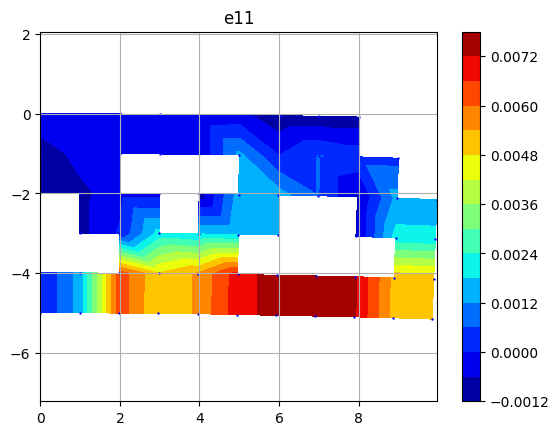

   number of nodes: 54
   number of elements: 76
   number of displacement boundary conditions: 16
   min displacements: u1=-0.001127, u2=-0.1395
   max displacements: u1=0.2161, u2=0.01031
   min strains: e11=-0.001337, e22=-0.01799, e12=-0.004837
   max strains: e11=0.006674, e22=0.003917, e12=0.005825
   min stress:  s11=-0.5478, s22=-2.108, s12=-0.186
   max stress:  s11=0.3379, s22=0.5038, s12=0.2241
   average strains: e11=0.006251, e22=-0.01612, e12=-8.666e-05
   average stress:  s11=-0.08857, s22=-1.81, s12=-0.003333
   average strain/nodes:  s11=11.65, s22=238.1, s12=0.4386
   average strain/nodes:  e11=0.8225, e22=2.121, e12=0.0114


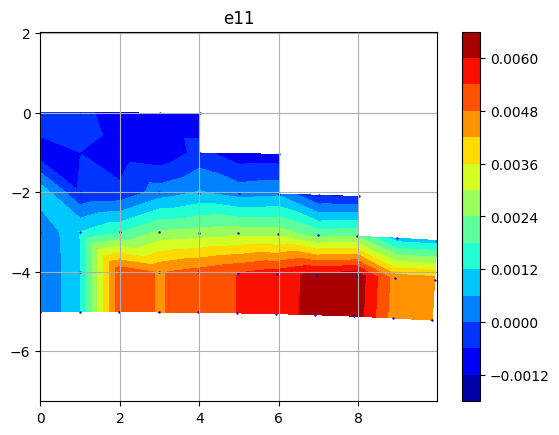

   number of nodes: 66
   number of elements: 100
   number of displacement boundary conditions: 16
   min displacements: u1=-0.001131, u2=-0.1145
   max displacements: u1=0.1463, u2=0.03254
   min strains: e11=-0.001416, e22=-0.01467, e12=-0.006225
   max strains: e11=0.005091, e22=0.00422, e12=0.006151
   min stress:  s11=-0.5387, s22=-1.716, s12=-0.2394
   max stress:  s11=0.437, s22=0.4865, s12=0.2366
   average strains: e11=0.004635, e22=-0.01221, e12=-6.264e-05
   average stress:  s11=-0.08044, s22=-1.376, s12=-0.002409
   average strain/nodes:  s11=8.044, s22=137.6, s12=0.2409
   average strain/nodes:  e11=0.4635, e22=1.221, e12=0.006264


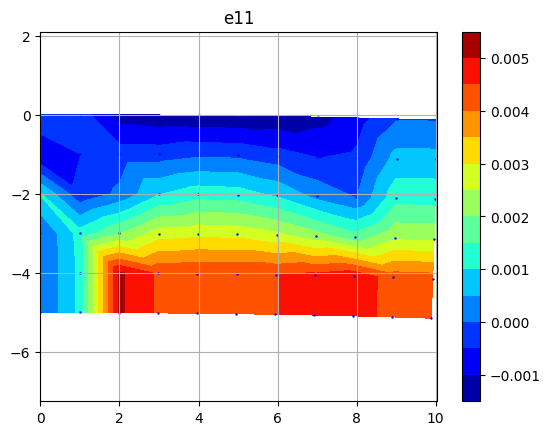

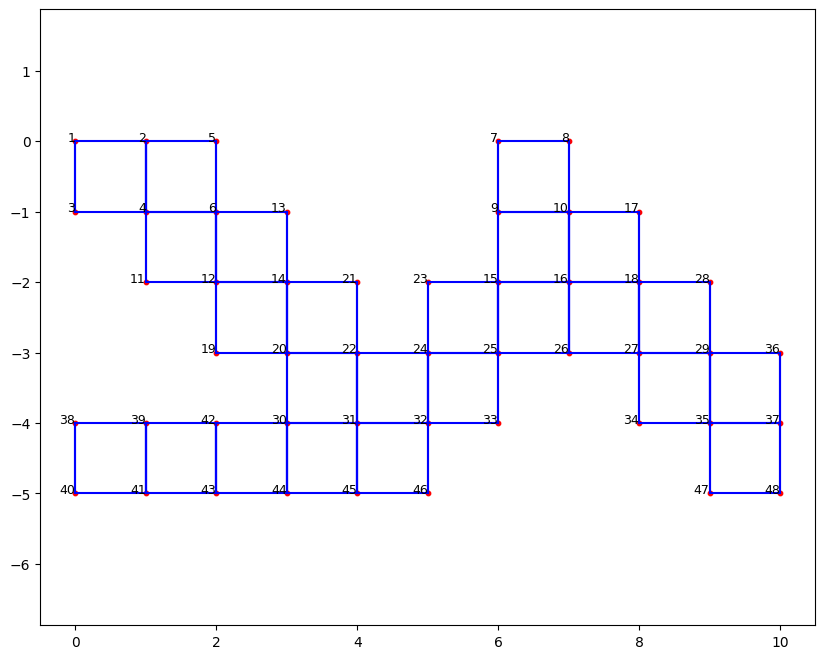

   number of nodes: 48
   number of elements: 48
   number of displacement boundary conditions: 16
   min displacements: u1=-0.0008333, u2=-1.994
   max displacements: u1=2.71, u2=1.205
   min strains: e11=-0.02344, e22=-0.07466, e12=-0.1073
   max strains: e11=0.0236, e22=0.03198, e12=0.1072
   min stress:  s11=-4.879, s22=-10.3, s12=-4.125
   max stress:  s11=4.426, s22=4.582, s12=4.123
   average strains: e11=0.01039, e22=-0.0255, e12=-2.932e-16
   average stress:  s11=-0.07216, s22=-2.833, s12=-1.121e-14
   average strain/nodes:  s11=15.03, s22=590.3, s12=2.335e-12
   average strain/nodes:  e11=2.165, e22=5.313, e12=6.108e-14


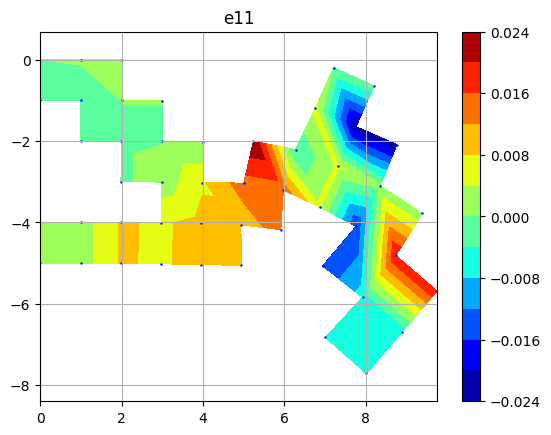

In [84]:
# Constants for the dimensions
_DESIGN = 0
_BOUND = 1
_LOADED_X = 2
_LOADED_Y = 3

height = 5
width = 10

# Initialize the design_space as a 3D matrix
design_space = np.zeros((4, height, width))

design_space2= np.zeros((4, height, width))
design_space3= np.zeros((4, height, width))
design_space4= np.zeros((4, height, width))
# Example design matrix
design_matrix = [
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
    [1, 1, 0, 0, 0, 1, 1, 1, 1, 0],
    [0, 1, 1, 0, 1, 1, 0, 0, 1, 1],
    [0, 0, 1, 1, 1, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
]

half_matrix = [[1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
               [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
               [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

full_matrix = np.ones((5, 10))

bad_design = [[1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
              [0, 1, 1, 0, 0, 0, 1, 1, 0, 0],
              [0, 0, 1, 1, 0, 1, 1, 1, 1, 0],
              [0, 0, 0, 1, 1, 1, 0, 0, 1, 1],
              [1, 1, 1, 1, 1, 0, 0, 0, 0, 1]]




# Assign the design matrix to the design_space
design_space[ _DESIGN, :, :] = scale_matrix(design_matrix, height, width)
design_space2[_DESIGN, :, :] = scale_matrix(half_matrix, height, width)
design_space3[_DESIGN, :, :] = scale_matrix(full_matrix, height, width)
design_space4[_DESIGN, :, :] = scale_matrix(bad_design, height, width)
# Example boundary conditions
design_space[_BOUND, 0, 0] = 1
design_space[_BOUND, -1, 0] = 1

design_space2[_BOUND, :, :] = design_space[_BOUND, :, :]
design_space3[_BOUND, :, :] = design_space[_BOUND, :, :]
design_space4[_BOUND, :, :] = design_space[_BOUND, :, :]

# Example loaded elements

design_space[_LOADED_Y, -1, -1] = -1

design_space2[_LOADED_Y, -1, -1] = -1
design_space3[_LOADED_Y, -1, -1] = -1
design_space4[_LOADED_Y, -1, -1] = -1


#print(design_space)

#print(extract_fem_data(design_space))

a,b,c, d = extract_fem_data(design_space)
# print(a, "\n", b, "\n", c, "\n", d)
# plot_mesh(a,b)
FEM(a,b,c,d)


a,b,c, d = extract_fem_data(design_space2)
FEM(a,b,c,d)
a,b,c, d = extract_fem_data(design_space3)
FEM(a,b,c,d)
a,b,c, d = extract_fem_data(design_space4)
plot_mesh(a,b)
FEM(a,b,c,d)

In [85]:
#TODO Create a function, that recognizes the edges of the given design and tries to run the connectig line along it

: 